In [25]:
import os
from pydub import AudioSegment
import numpy as np
import matplotlib.pyplot as plt
from feature_extractors import MfccFeatureExtractor
from sklearn.manifold import TSNE
from scipy import *
import python_speech_features

In [71]:
path = "/home/jugs/Downloads/PresidentAudio/" #"/home/jugs/PycharmProjects/THU_SR/src/Recordings/Zh/enroll/" #"/home/jugs/Downloads/o/pred_pres/" #"/home/jugs/Downloads/PresidentAudio/"   # "/home/jugs/Audio/default_voice/"
result = [os.path.join(dp, f) for dp, dn, filenames in os.walk(path) for f in filenames if os.path.splitext(f)[1] == '.wav']
labels = []
files = []
stacked = np.zeros((len(result),5187), dtype=float)

In [72]:
for idx, file in enumerate(result):
    files.append(file)
    labels.append(file.split('/')[5])
    

In [68]:
# print(labels)

In [73]:
def mfcc(y, sr, numcep=13, delta=False, delta_delta=False, width=2, **kwargs):
    """
    Compute MFCCs of Audio Signal
    :param y: Audio signal
    :param sr: Original sample rate
    :param numcep: Number of MFCCs to compute
    :param delta: If delta of MFCCs are required
    :param delta_delta: If acceleration of MFCCs are required
    :param width: Number of samples to consider for computing delta
    :param kwargs: Other parameters to pass on python_speech_features like hop length etc.
    :return: MFCCs (numpy array of shape n_frames * n_mfccs)
    """
    mfccs = python_speech_features.mfcc(signal=y, samplerate=sr, numcep=numcep, **kwargs)
    if delta:
        d1 = python_speech_features.delta(mfccs, N=width)
        mfccs = np.hstack((mfccs, d1))
    if delta_delta:
        d2 = python_speech_features.delta(mfccs[:, mfccs.shape[1] / 2:], N=width)
        mfccs = np.hstack((mfccs, d2))
    return mfccs

In [74]:
def normalize_audio(y):
    """
    Normalize amplitudes to lie between -1 to 1
    :param y: Audio signal
    :return: Normalized Audio signal
    """
    # Todo : study other normalizing methods like rms normalizing
    y = y * 1.0
    return y / np.max(np.abs(y))

In [75]:
def remove_dc_offset(y):
    """
    Remove DC offset from audio signal
    :param y: Audio signal
    :return: Signal without DC offset
    """
    return y - np.mean(y)

In [81]:
for i,file in enumerate(files):
    audio = AudioSegment.from_file(file)
#     print(file)
    y, sr = np.array(audio.get_array_of_samples(), dtype=float), audio.frame_rate
    y = normalize_audio(remove_dc_offset(y))
    mfccs = mfcc(y=y, sr=sr)
    
#     plt.figure(figsize=(12,4))
#     plt.ylabel("MFCCs")
#     plt.xlabel("Frames")
#     plt.title("MFCC")
#     plt.imshow(mfccs.T, origin=(0,0), aspect='auto', cmap='viridis')
#     plt.colorbar()
#     plt.show()
    stacked[i] = mfccs.flatten()


In [82]:
def plot_embedding(X, title="tsne dim reduction"):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], 
                 labels[i],
                 color= 'red',
                 fontdict={'weight': 'bold', 'size': 6})
    if title is not None:
        plt.title(title)

In [83]:
embedder = TSNE(n_components=2, verbose=1, init='pca', random_state=0)
x_tsne = embedder.fit_transform(stacked)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 210 samples in 0.022s...
[t-SNE] Computed neighbors for 210 samples in 0.328s...
[t-SNE] Computed conditional probabilities for sample 210 / 210
[t-SNE] Mean sigma: 283.102207
[t-SNE] KL divergence after 250 iterations with early exaggeration: 90.506821
[t-SNE] Error after 1000 iterations: 0.483971


In [84]:
print(stacked.shape)
print(x_tsne.shape)

(210, 5187)
(210, 2)


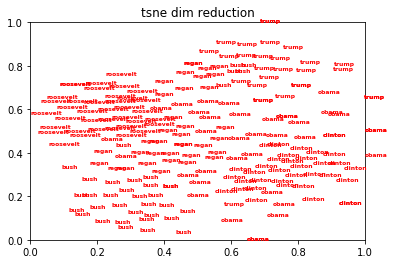

In [87]:
plot_embedding(x_tsne)
plt.savefig("mfccs_cust.png", bbox_inches='tight', dpi=720)
plt.show()